Пример строк из датасета:
                               query            track_name             author  \
35  калинов мост время колокольчиков                Циклон       Калинов Мост   
57              поставь группу т и т        Нас не догонят           t.A.T.u.   
19           включи песню оп мусорок               Мусорок  Александр Новиков   
55                       включи face                     証               FACE   
29                       включи лепс  Рюмка водки на столе      Григорий Лепс   

   golden_answer  
35        notrel  
57        notrel  
19        notrel  
55      rel_plus  
29      rel_plus  

=== Запросы и ответы модели ===


➡️ Запрос #1
Запрос пользователя: включи козина
Трек: Cozinha
Исполнитель: Volbru
Ответ модели:
Оценка: rel_plus
Обоснование: Название трека "Cozinha" фонетически близко к слову "козина", что делает его потенциально релевантным. Однако исполнитель не является широко известным и название отличается от запроса, поэтому это скорее условно-


➡️ Запрос #70
Запрос пользователя: включи песню швайне
Трек: Швайне
Исполнитель: Глюк’oZa
Ответ модели:
К сожалению, иногда генеративные языковые модели могут создавать некорректные ответы, основанные на открытых источниках. Во избежание неправильного толкования, ответы на вопросы, связанные с чувствительными темами, временно ограничены. Благодарим за понимание.

➡️ Запрос #71
Запрос пользователя: песня цыки цык
Трек: Цыка най
Исполнитель: Рустам Нахушев
Ответ модели:
Оценка: rel_minus
Обоснование: Название трека содержит схожий звук "цык", однако это не точное совпадение с искомой фразой "цыки цык". Исполнитель и название трека не полностью соответствуют ожиданиям пользователя.

➡️ Запрос #72
Запрос пользователя: включи индийскую музыку
Трек: Индийская народная песня
Исполнитель: Дмитрий Миленький
Ответ модели:
Оценка: rel_plus
Обоснование: Трек является индийской музыкой, так как это индийская народная песня. Однако, исполнение Дмитрием Миленьким может не полностью соответствовать о

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

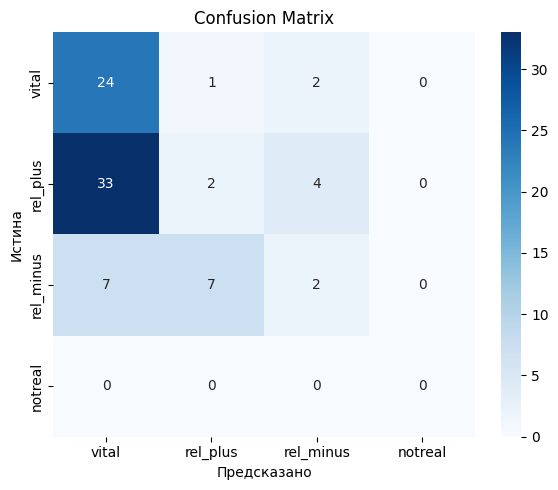

In [ ]:
# Установка библиотек (один раз)
!pip install gigachain-community scikit-learn pandas matplotlib seaborn

# Импорт библиотек
import pandas as pd
import base64
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.chat_models.gigachat import GigaChat
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка датасета
test = pd.read_csv('valid_set.tsv', sep='\t')
print("Пример строк из датасета:")
print(test.sample(5))

# Авторизация GigaChat
# Введите свои значения
client_id = "..."
client_secret = "..."

# Кодирование credentials в Base64
raw_credentials = f"{client_id}:{client_secret}"
encoded_credentials = base64.b64encode(raw_credentials.encode()).decode()

# Инициализация LLM
llm = GigaChat(
    credentials=encoded_credentials,
    scope="GIGACHAT_API_PERS",
    model="GigaChat-Pro",
    verify_ssl_certs=False,
    streaming=False,
)

# System prompt
system_prompt = """
Ты эксперт по оценке качества поиска музыки.
Твоя задача — оценить, насколько найденный трек соответствует пользовательскому запросу.

Используй строго одну из 4 оценок:
- vital
- rel_plus
- rel_minus
- notreal

Ответ должен быть в формате:
Оценка: <одна из четырёх>
Обоснование: <объяснение почему выбрана именно эта оценка>
""".strip()

# User prompt
def format_user_prompt(query, track_name, author):
    return f"""
Запрос: {query}
Найденный трек: {track_name}
Исполнитель: {author}

Оцени релевантность и выдай только:
Оценка: ...
Обоснование: ...
""".strip()

# Генерация предсказаний
predictions = []
raw_responses = []

print("\n=== Запросы и ответы модели ===\n")

for i, row in test.iterrows():
    query = row['query']
    track = row['track_name']
    author = row['author']

    user_prompt = format_user_prompt(query, track, author)
    messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(content=user_prompt)
    ]

    try:
        response = llm.invoke(messages)
        raw_responses.append(response.content)

        # Печать запроса и ответа
        print(f"\n➡️ Запрос #{i+1}")
        print(f"Запрос пользователя: {query}")
        print(f"Трек: {track}")
        print(f"Исполнитель: {author}")
        print("Ответ модели:")
        print(response.content)

        # Извлечение оценки
        found = False
        for line in response.content.split('\n'):
            if 'Оценка:' in line:
                label = line.split("Оценка:")[1].strip().lower()
                predictions.append(label)
                found = True
                break
        if not found:
            predictions.append("unknown")

    except Exception as e:
        print(f"Ошибка при обработке строки {i}: {e}")
        predictions.append("unknown")
        raw_responses.append("Ошибка")

# 📊 Метрики
y_true = test['golden_answer'].tolist()
y_pred = predictions

print("\n=== 📈 Метрики классификации ===\n")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))

# Confusion matrix
labels = ["vital", "rel_plus", "rel_minus", "notreal"]
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Предсказано")
plt.ylabel("Истина")
plt.tight_layout()
plt.show()
